### Load the DataFrame

In [1]:
import pandas as pd
import scipy.sparse as sp
import scipy.stats as stats
import scipy.sparse.linalg as spla
import sklearn.cluster
import numpy as np
import matplotlib.pyplot as plt
import datashader as ds
from bokeh.plotting import figure, output_notebook, show
%matplotlib inline

datasetfname = "uspto_grants_all_H_sections.hdf5"
try:
    df
except NameError:
    df = pd.read_hdf(datasetfname)
df.reset_index(inplace=True,drop=True)

### Produce an adjacency matrix where vertices are the patents (vertex i corresponds to row i of the dataset) and an edge indicates that vertices i and j have the relation cites or is cited by in the original dataset, or they share a cited patent that is or is not in the dataset

In [2]:
patentNums = df["publishedPatentDocNumber"].tolist()
applicantCitations = df["applicantCitations"].tolist()
examinerCitations = df["examinerCitations"].tolist()

uniqueCitations = set([])
for idx in xrange(len(applicantCitations)):
    uniqueCitations.update(applicantCitations[idx]) 
for idx in xrange(len(examinerCitations)):
    uniqueCitations.update(examinerCitations[idx])
    
vertexList = list(patentNums)
vertexList.extend(uniqueCitations)

docToVertexLUT = {}
for idx in xrange(len(vertexList)):
    docToVertexLUT[vertexList[idx]] = idx
    
# B = csr_matrix((data, indices, colIndexPointers)) will be a
# patents-by-numvertices adjacency matrix stored in CSR format
colIndexPointers = [0]*(len(patentNums)+1)
for rowNum in xrange(len(patentNums)):
    colIndexPointers[rowNum+1] = colIndexPointers[rowNum] + len(applicantCitations[rowNum]) + len(examinerCitations[rowNum])
    
indices = [0]*colIndexPointers[-1]
for rowNum in xrange(len(patentNums)):
    if (rowNum % 50000 == 0):
        print('Populating row {0} of {1}'.format(rowNum, len(patentNums)))
    citations = applicantCitations[rowNum]
    citations.extend(examinerCitations[rowNum])
    indices[colIndexPointers[rowNum]:colIndexPointers[rowNum+1]] = map(lambda doc: docToVertexLUT[doc], citations) 
    
data = [1]*len(indices)
B = sp.csr_matrix((data, indices, colIndexPointers))
C = np.dot(B, B.T)
C = C + C.T

Populating row 0 of 666137
Populating row 50000 of 666137
Populating row 100000 of 666137
Populating row 150000 of 666137
Populating row 200000 of 666137
Populating row 250000 of 666137
Populating row 300000 of 666137
Populating row 350000 of 666137
Populating row 400000 of 666137
Populating row 450000 of 666137
Populating row 500000 of 666137
Populating row 550000 of 666137
Populating row 600000 of 666137
Populating row 650000 of 666137


### Make C into a genuine adjacency matrix A

In [3]:
(i,j,v) = sp.find(C)
for idx in xrange(len(v)):
    if i[idx] == j[idx]:
        v[idx] = 0
    else:
        v[idx] = 1.0
A = sp.coo_matrix((v, (i,j)), shape=C.shape, dtype='d').tocsr()

### Fit an SBM

In [26]:
k = 100
(U,s,V) = spla.svds(A, k)
S = np.diagflat(np.sqrt(s))
Xhat = np.dot(U,S)
kmeans_obj = sklearn.cluster.KMeans(k, n_init=1, max_iter=10)
labels = kmeans_obj.fit_predict(Xhat)
plt.scatter(Xhat[:, 8], Xhat[:, 6], c=labels)

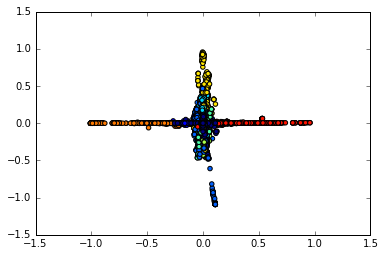

In [39]:
plt.scatter(Xhat[:, 0], Xhat[:, 1], c=labels)

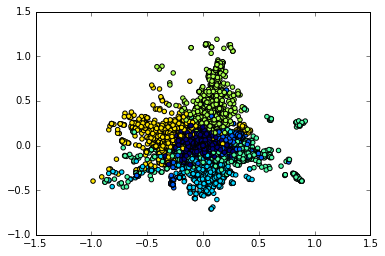

In [40]:
plt.scatter(Xhat[:, 2], Xhat[:, 3], c=labels)

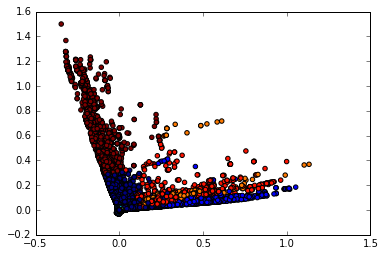

In [41]:
plt.scatter(Xhat[:, 5], Xhat[:, 7], c=labels)

### Export the entire adjacency matrix

In [ ]:
adjacencymatfname = "one_hop_adjacency_all_H.txt"

def export_sparsemat(spmat, outfname):
    (i,j,v) = sp.find(spmat)
    with open(outfname, "w") as fout:
        for idx in xrange(len(i)):
            if (i[idx] == j[idx]):
                continue
            if (idx % 100000 == 0):
                print("Exporting edge {0} of {1}".format(idx+1, len(i)))
            fout.write("{0} {1}\n".format(i[idx], j[idx]))
export_sparsemat(C, adjacencymatfname)

### Export positive samples

In [34]:
numpositives = 15000
posexamplesIndices = np.random.choice(len(i), numpositives)
iPos = i[posexamplesIndices]
jPos = j[posexamplesIndices]
outfname = "positive_edges.txt"
with open(outfname, "w") as fout:
    for idx in xrange(numpositives):
        fout.write("{0} {1}\n".format(iPos[idx], jPos[idx]))


In [5]:
from functools import partial
from IPython.core.display import HTML, display
from bokeh.plotting import figure, output_notebook, show

from scipy.sparse import coo_matrix, csr_matrix
import cPickle as pickle

import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from datashader import transfer_functions as tf
from datashader.colors import Greys9

from bokeh.plotting import figure, output_notebook, show

In [10]:
def permute(adjacency_matrix, labels):
    n = adjacency_matrix.shape[0]

    adjacency_matrix = coo_matrix(adjacency_matrix)
    row = np.copy(adjacency_matrix.row)
    col = np.copy(adjacency_matrix.col)
    val = np.copy(adjacency_matrix.data)
    nnz = len(val)

    matrix = csr_matrix(coo_matrix((val, (row, col)), shape = (n, n)))
    mapping = []
    for label in set(labels):
        mapping.extend(list(np.where(labels==label)[0]))

    return csr_matrix(coo_matrix( (val, ([mapping[r] for r in row], [mapping[c] for c in col])), (n, n)))

def base_plot(tools='pan,wheel_zoom,reset', 
              x_range=x_range, 
              y_range=y_range, 
              plot_width=plot_width, 
              plot_height=plot_height,
              **plot_args):
    
    p = figure(tools=tools,
               x_range=x_range, 
               y_range=y_range,               
               plot_width=plot_width, 
               plot_height=plot_height,
               outline_line_color=None,
               min_border=0, 
               min_border_left=0, 
               min_border_right=0,
               min_border_top=0, 
               min_border_bottom=0, 
               **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

Loading BokehJS ...

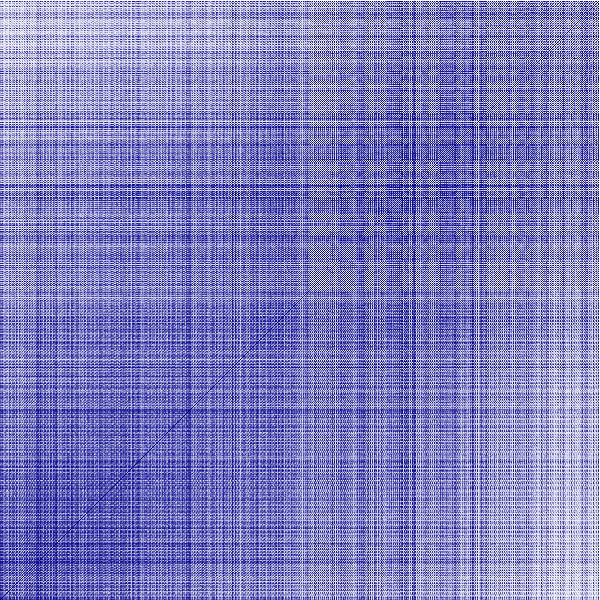

In [62]:
df = pd.DataFrame.from_dict({'x': i, 'y': j, 'z': v})
"""
Greys9_r   = list(reversed(Greys9))[:-2]
background = "white"
export = partial(export_image, export_path="export", background=background)
cm     = partial(colormap_select, reverse=(background=="white"))
"""
x_range = df['x'].min(), df['x'].max()
y_range = df['y'].min(), df['y'].max()
plot_width  = 600
plot_height = 600

output_notebook()
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
agg = cvs.points(df, 'x', 'y',  ds.count('z'))
img = tf.interpolate(agg, cmap=["white", 'darkblue'], how='eq_hist')
img

In [63]:
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y',  ds.count('z'))
    img = tf.interpolate(agg, cmap=["white", 'darkblue'], how='eq_hist')
    return tf.dynspread(img, threshold=0, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image(x_range, y_range),"Adjacency")
InteractiveImage(p, create_image)

In [ ]:
k = 600
(U,s,V) = spla.svds(A, k)
S = np.diagflat(np.sqrt(s))

In [ ]:
Xhat = np.dot(U,S)
kmeans_obj = sklearn.cluster.KMeans(k, n_init=1, max_iter=10)
labels = kmeans_obj.fit_predict(Xhat)

Apermuted = permute(A, labels)
(ip,jp,vp) = sp.find(Apermuted)
df = pd.DataFrame.from_dict({'x': ip, 'y': jp, 'z': vp})

In [ ]:
Greys9_r   = list(reversed(Greys9))[:-2]
background = "white"
export = partial(export_image, export_path="export", background=background)
cm     = partial(colormap_select, reverse=(background=="white"))

x_range = df['x'].min(), df['x'].max()
y_range = df['y'].min(), df['y'].max()
plot_width  = 600
plot_height = 600

output_notebook()
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
agg = cvs.points(df, 'x', 'y',  ds.count('z'))
img = tf.interpolate(agg, cmap=["white", 'darkblue'], how='eq_hist')
img

Loading BokehJS ...

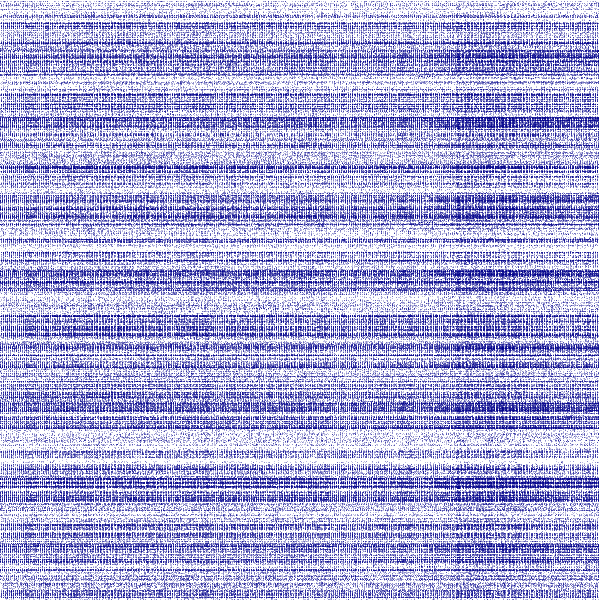

In [97]:
n = Apermuted.shape[0]
Asubmat = Apermuted[:, 90000:100000]
(isub, jsub, vsub) = sp.find(Asubmat)
df = pd.DataFrame.from_dict({'x': isub, 'y': jsub, 'z': vsub})

x_range = df['x'].min(), df['x'].max()
y_range = df['y'].min(), df['y'].max()
plot_width  = 600
plot_height = 600

output_notebook()
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
agg = cvs.points(df, 'x', 'y',  ds.count('z'))
img = tf.interpolate(agg, cmap=["white", 'darkblue'], how='eq_hist')
img

In [86]:
Asubmat.nnz/float(np.prod(Asubmat.shape))

0.0